In [1]:
import sys
sys.path.insert(0, "/home/forest")
import warnings
warnings.filterwarnings('ignore')

In [2]:
from voxelgrid import VoxelGrid
import h5py
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from skimage.transform import resize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
with h5py.File('/home/forest/data/dataset/3D_mnist/train_point_clouds.h5', 'r') as hf:
    a = hf["0"]
    b = hf["1"]
    digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
    digit_b = (b["img"][:], b["points"][:], b.attrs["label"]) 

In [4]:
a_voxelgrid = VoxelGrid(digit_a[1], x_y_z=[16, 16, 16])
b_voxelgrid = VoxelGrid(digit_b[1], x_y_z=[16, 16, 16])

In [5]:
a_voxelgrid.vector.shape

(16, 16, 16)

In [6]:
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

def normalize(arr):
    return arr/ np.max(arr)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

IMG_DIM = 32
def plot_vector(vector):
    vector_resized = resize(vector, 
                 (IMG_DIM, IMG_DIM, IMG_DIM/2), mode='constant')
    vector_normalize = normalize(vector_resized)
    
    facecolors = cm.inferno(vector_normalize)
    facecolors[:,:,:,-1] = vector_normalize
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca(projection='3d')
    ax.view_init(220, 30)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors)
    plt.show()

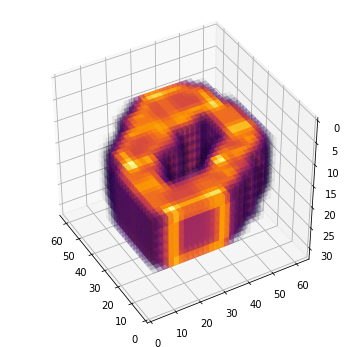

In [7]:
plot_vector(b_voxelgrid.vector)

In [8]:
with h5py.File("/home/forest/data/dataset/3D_mnist/train_point_clouds.h5", "r") as hf:
    size = len(hf.keys())
    # tuple to store the vectors and labels
    out = (np.zeros((size, 16*16*16), dtype="f"), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 800 == 0:
            print(i, "\t processed")
        voxelgrid = VoxelGrid(hf[str(i)]["points"][:], x_y_z=[16, 16, 16])
        # make the vector range 0-1
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
        out[1][i] = hf[str(i)].attrs["label"]
    print("[DONE]")
    X_train, y_train = out

0 	 processed
800 	 processed
1600 	 processed
2400 	 processed
3200 	 processed
4000 	 processed
4800 	 processed
[DONE]


In [9]:
with h5py.File("/home/forest/data/dataset/3D_mnist/test_point_clouds.h5", "r") as hf:
    size = len(hf.keys())
    # tuple to store the vectors and labels
    out = (np.zeros((size, 16*16*16), dtype="f"), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 400 == 0:
            print(i, "\t processed")
        voxelgrid = VoxelGrid(hf[str(i)]["points"][:], x_y_z=[16, 16, 16])
        # make the vector range 0-1
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)
        out[1][i] = hf[str(i)].attrs["label"]
    print("[DONE]")
    X_valid, y_valid = out

0 	 processed
400 	 processed
800 	 processed
[DONE]


In [69]:
from datetime import datetime

tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [70]:
X = tf.placeholder(shape=[None, 16, 16, 16, 1], dtype=tf.float32, name="X")


caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 5 * 5 * 5# 2686主胶囊们
caps1_n_dims = 8



conv1_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256个卷积滤波器
    "kernel_size": 4,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256个卷积滤波器
    "kernel_size": 4,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv1 = tf.layers.conv3d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv3d(conv1, name="conv2", **conv2_params)

caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")


def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope("Squash") as scope:    
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True, name="squared_norm")
        safe_norm = tf.sqrt(squared_norm + epsilon, name="safe_norm")
        squash_factor = tf.div(squared_norm , (1. + squared_norm), name="squash_factor")
        unit_vector = tf.div(s, safe_norm, name="unit_vector")
        return tf.multiply(squash_factor, unit_vector, name=name)

    
caps1_output = squash(caps1_raw, name="caps1_output")

caps2_n_caps = 10
caps2_n_dims = 16

init_sigma = 0.1

with tf.name_scope("expand_w_dimensions") as scope:   
    W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
           stddev=init_sigma, dtype=tf.float32, name="W_init")
    W = tf.Variable(W_init, name="W")
    batch_size = tf.shape(X)[0]
    W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

with tf.name_scope("expand_caps1_output_dimensions") as scope:   
    caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                           name="caps1_output_expanded")
    caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                       name="caps1_output_tile")
    caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                                 name="caps1_output_tiled")

    
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")


  
def routing(w, name=None):
    with tf.name_scope("routing") as scope:   
        routing_weights = tf.nn.softmax(w, 
                                        dim=2,
                                        name="routing_weights")
        weighted_predictions = tf.multiply(routing_weights, 
                                           caps2_predicted,
                                           name="weighted_predictions")
        weighted_sum = tf.reduce_sum(weighted_predictions, 
                                     axis=1, keep_dims=True,
                                     name="weighted_sum")
        return squash(weighted_sum, axis=-2, name=name)



def condition(input, counter):
    return tf.less(counter, 3)

def loop_body(input, counter):
    caps2_output = routing(input, name="caps2_output")
    with tf.name_scope("update_weights") as scope:
        caps2_output_tiled = tf.tile(caps2_output, [1, caps1_n_caps, 1, 1, 1],
                                     name="caps2_output_tiled")
        agreement = tf.matmul(caps2_predicted, caps2_output_tiled,
                             transpose_a=True, name="agreement")
        output = tf.add(input, agreement, name="raw_weights_updated")
    return output, tf.add(counter, 1.0)
        
with tf.name_scope("routing_layer"):
    counter = tf.constant(1.0, dtype=np.float32)
    raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                           dtype=np.float32, name="raw_weights")
    raw_weights_final,counters = tf.while_loop(condition, loop_body, [raw_weights, counter])

caps2_output = routing(raw_weights_final, name="caps2_output")


def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)
    
with tf.name_scope("get_y_pred") as scope:   
    y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")
    y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

with tf.name_scope("calculate_margin_loss") as scope:  
    T = tf.one_hot(y, depth=caps2_n_caps, name="T")
    caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                                  name="caps2_output_norm")
    present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                                  name="present_error_raw")
    present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                               name="present_error")
    absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                                 name="absent_error_raw")
    absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                              name="absent_error")
    L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
               name="L")
    margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

with tf.name_scope("mask_caps2_output") as scope:  
    mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                                   name="mask_with_labels")
    reconstruction_targets = tf.cond(mask_with_labels, # 条件
                                     lambda: y,        # if True
                                     lambda: y_pred,   # if False
                                     name="reconstruction_targets")
    reconstruction_mask = tf.one_hot(reconstruction_targets,
                                     depth=caps2_n_caps,
                                     name="reconstruction_mask")
    reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
                                              name="reconstruction_mask_reshaped")
    caps2_output_masked = tf.multiply(caps2_output, 
                                      reconstruction_mask_reshaped,
                                      name="caps2_output_masked")

decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

n_hidden1 = 512
n_hidden2 = 2048
n_hidden3 = 8192
n_output = 16 * 16 * 16

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3,
                              activation=tf.nn.relu,
                              name="hidden3")
    decoder_output = tf.layers.dense(hidden3, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

with tf.name_scope("total_loss"):
    with tf.name_scope("get_reconstruction_loss"):
        X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
        squared_difference = tf.square(X_flat - decoder_output,
                                       name="squared_difference")
        reconstruction_loss = tf.reduce_mean(squared_difference,
                                             name="reconstruction_loss")
    alpha = 0.0005
    loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

with tf.name_scope("accuracy"):
    correct = tf.equal(y, y_pred, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

In [56]:
2048*4

8192

In [19]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

In [71]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
margin_loss_summary = tf.summary.scalar('Margin_losss', margin_loss)
reconstruction_loss_summary = tf.summary.scalar('Reconstruction_loss', reconstruction_loss)
loss_summary = tf.summary.scalar('Loss', loss)
accur_summary = tf.summary.scalar('Accuracy', accuracy)
Caps2_output_summary = tf.summary.histogram('Caps2_output', caps2_output)
raw_weights_summary = tf.summary.histogram('raw_weights', raw_weights)
merged_summary = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [72]:
n_epochs = 15
batch_size = 25
restore_checkpoint = True

n_iterations_per_epoch = X_train.shape[0] // batch_size
n_iterations_validation = X_valid.shape[0] // batch_size
best_loss_val = np.infty
checkpoint_path = "/home/forest/data/capsule/model/Capsule_3Dmnist_model13"

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch = X_train[(iteration-1)*batch_size: iteration*batch_size]
            y_batch = y_train[(iteration-1)*batch_size: iteration*batch_size]
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 16, 16, 16, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            if iteration % 10 == 1:
                summary_str = merged_summary.eval(feed_dict={X: X_batch.reshape([-1, 16, 16, 16, 1]),
                                                             y: y_batch})
                step = epoch * n_iterations_per_epoch + iteration - 1
                file_writer.add_summary(summary_str, step)
            # 运行训练操作并且评估损失:


        # 在每个epoch之后，
        # 衡量验证损失和精度：
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch = X_valid[(iteration-1)*batch_size: iteration*batch_size]
            y_batch = y_valid[(iteration-1)*batch_size: iteration*batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 16, 16, 16, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # 如果有进步就保存模型：
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 89.1000%  Loss: 0.137526 (improved)
Epoch: 2  Val accuracy: 92.3000%  Loss: 0.097787 (improved)
Epoch: 3  Val accuracy: 94.1000%  Loss: 0.077356 (improved)
Epoch: 4  Val accuracy: 95.0000%  Loss: 0.070103 (improved)
Epoch: 5  Val accuracy: 94.9000%  Loss: 0.065286 (improved)
Epoch: 6  Val accuracy: 94.9000%  Loss: 0.058074 (improved)
Epoch: 7  Val accuracy: 94.5000%  Loss: 0.058519
Epoch: 8  Val accuracy: 94.9000%  Loss: 0.054224 (improved)
Epoch: 9  Val accuracy: 94.9000%  Loss: 0.059629
Iteration: 74/200 (37.0%)  Loss: 0.00426

KeyboardInterrupt: 

In [ ]:
y_batch

In [ ]:
index